In [2]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")

In [6]:
%pwd

'/content'

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
pip install py7zr

     |████████████████████████████████| 4.3 MB 9.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 357 kB 65.7 MB/s 
     |████████████████████████████████| 43 kB 2.8 MB/s 
     |████████████████████████████████| 2.0 MB 60.7 MB/s 
     |████████████████████████████████| 131 kB 76.9 MB/s 
     |████████████████████████████████| 57 kB 8.4 MB/s 
     |████████████████████████████████| 2.4 MB 52.9 MB/s 
  Created wheel for py7zr: filename=py7zr-0.18.5-py3-none-any.whl size=69901 sha256=e5528df811822ab37ed55364eae0a53dad48d547fbfdb2d283d837ad9973605d
  Stored in directory: /root/.cache/pip/wheels/c8/f6/f8/9a860b95b853b2a891d478d2d2afde2fc0460514a7015d15d5
Successfully built py7zr


In [8]:
import py7zr

archive = py7zr.SevenZipFile('/content/drive/MyDrive/MAJOR PROJECT/train.7z', mode='r')
archive.extractall(path="content")
archive.close()

In [9]:
archive = py7zr.SevenZipFile('/content/drive/MyDrive/MAJOR PROJECT/test.7z', mode='r')
archive.extractall(path="content")
archive.close()

In [10]:
os.listdir('/content')

['.config', 'content', 'drive', 'sample_data']

In [11]:
%pwd

'/content'

**Data Exploration and Visualization**



**Visualization of Audio signal in time series domain**


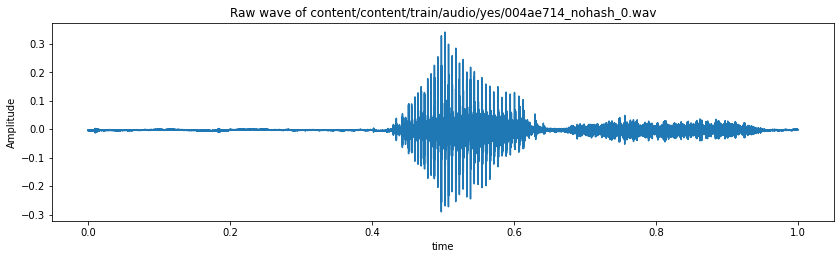

In [12]:
train_audio_path = 'content/train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'yes/004ae714_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + 'content/content/train/audio/yes/004ae714_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [13]:
ipd.Audio(samples, rate=sample_rate)

In [14]:
print(sample_rate)

16000


**Resampling**

In [15]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

In [16]:
labels=os.listdir(train_audio_path)

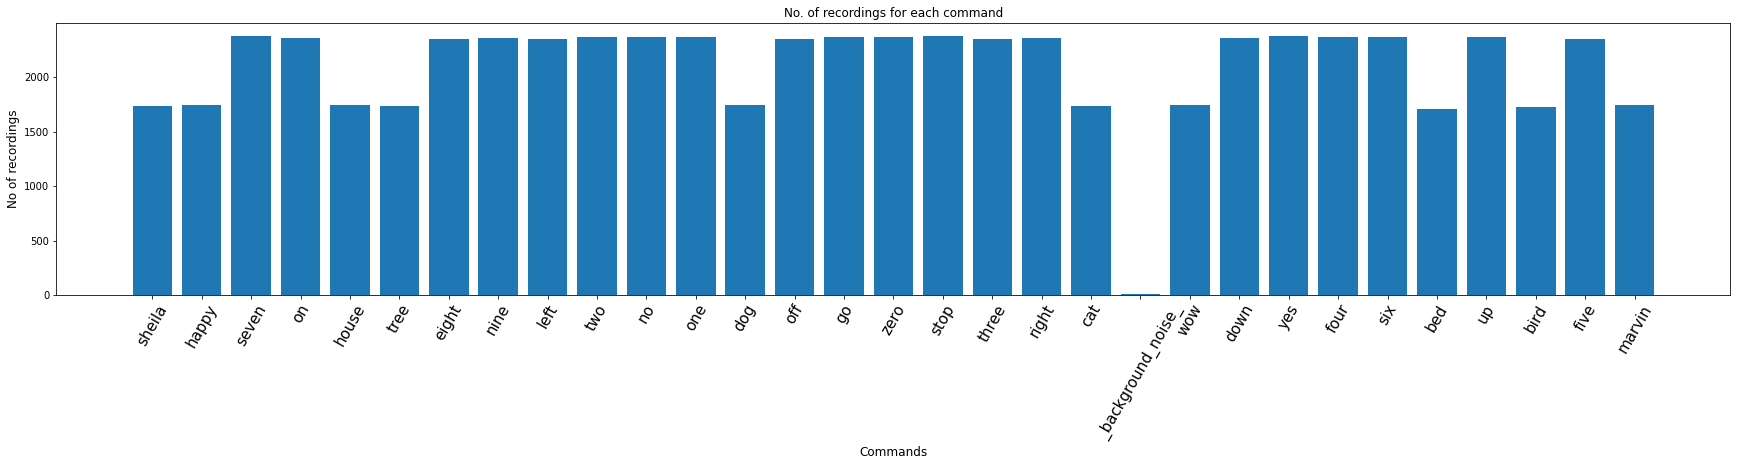

In [17]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [18]:
labels=os.listdir(train_audio_path)

(array([6.4721e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.3715625 ,  9.85271875, 19.333875  , 28.81503125, 38.2961875 ,
        47.77734375, 57.2585    , 66.73965625, 76.2208125 , 85.70196875,
        95.183125  ]),
 <a list of 10 Patch objects>)

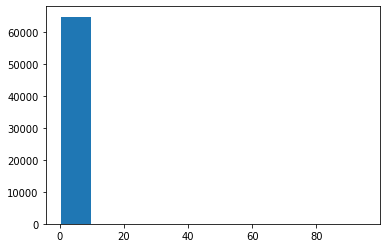

In [19]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

(0.0, 1.0)

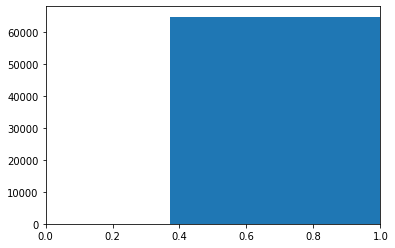

In [20]:
plt.hist(np.array(duration_of_recordings))
plt.xlim([0,1])

**Preprocessing the audio waves**


In [21]:
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

sheila
happy
seven
on
house
tree
eight
nine
left
two
no
one
dog
off
go
zero
stop
three
right
cat
_background_noise_
wow
down
yes
four
six
bed
up
bird
five
marvin


In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [23]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [24]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

**Split into train and validation set**

In [25]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

**Model building**

In [26]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

In [27]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [28]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [29]:
y_tr.shape

(46601, 31)

In [30]:
x_tr.shape

(46601, 8000, 1)

In [31]:
x_val.shape

(11651, 8000, 1)

In [32]:
y_val.shape

(11651, 31)

In [33]:
%pwd

'/content'

In [34]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc],batch_size = 32, validation_data=(x_val,y_val))

Epoch 1/100
1457/1457 [==============================] - 25s 10ms/step - loss: 2.8474 - accuracy: 0.1524 - val_loss: 2.1486 - val_accuracy: 0.3224
Epoch 2/100
1457/1457 [==============================] - 12s 8ms/step - loss: 1.9493 - accuracy: 0.3887 - val_loss: 1.6415 - val_accuracy: 0.4874
Epoch 3/100
1457/1457 [==============================] - 13s 9ms/step - loss: 1.5422 - accuracy: 0.5186 - val_loss: 1.1969 - val_accuracy: 0.6410
Epoch 4/100
1457/1457 [==============================] - 13s 9ms/step - loss: 1.3451 - accuracy: 0.5841 - val_loss: 1.0152 - val_accuracy: 0.7053
Epoch 5/100
1457/1457 [==============================] - 13s 9ms/step - loss: 1.2315 - accuracy: 0.6210 - val_loss: 0.9610 - val_accuracy: 0.7127
Epoch 6/100
1457/1457 [==============================] - 12s 8ms/step - loss: 1.1454 - accuracy: 0.6499 - val_loss: 0.8935 - val_accuracy: 0.7363
Epoch 7/100
1457/1457 [==============================] - 13s 9ms/step - loss: 1.0774 - accuracy: 0.6681 - val_loss: 0.8439 

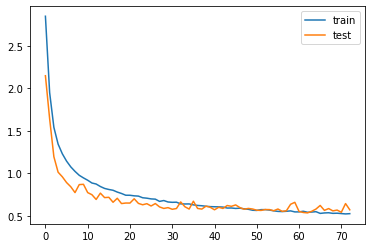

In [35]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Loading the best model**

from keras.models import load_model
model=load_model('best_model.hdf5')

Define the function that predicts text for the given audio:

In [36]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

Prediction time! Make predictions on the validation data:

In [37]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: dog


In [38]:
print("Text:",predict(samples))

Text: dog
